In [214]:
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import (
    QuantumCircuit,
    transpile,
    assemble,
    QuantumRegister,
    ClassicalRegister,
)

from qiskit_aer.noise import NoiseModel
# import basic plot tools
from qiskit.visualization import plot_histogram

import random
import numpy as np

In [215]:
secret_bit_string = input("Enter secret bit string: ")
n = len(secret_bit_string)

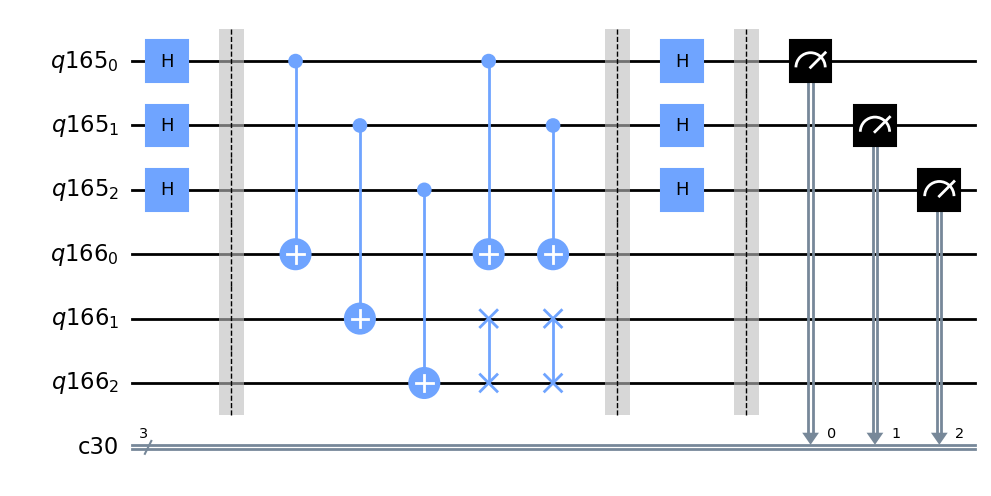

In [222]:
# input quantum register size n
input_q_reg = QuantumRegister(n)

# output quantum register size n
output_q_reg = QuantumRegister(n)

# classical register size n
c_reg = ClassicalRegister(n)

# create a quantum circuit with the input and output quantum registers, classical registers of size n
simons_circuit = QuantumCircuit(input_q_reg, output_q_reg, c_reg)

# apply hadamard gates to the input quantum register
simons_circuit.h(input_q_reg)

# barrier for visual separation
simons_circuit.barrier()

# oracle implementation
# Gates implementing the function f(a) = f(b) iff a ⨁ b = s

# copy input to output
simons_circuit.cx(input_q_reg, output_q_reg)

significant = secret_bit_string.index("1")

for j in range(n):
    if secret_bit_string[j] == "1":
        simons_circuit.cx(input_q_reg[j], output_q_reg[significant])

# random dict with keys 0 to n and values 0 to n (one one mapping)
domain = list(range(n))
codomain = list(range(n))
random.shuffle(codomain)
mapping_dict = dict(zip(domain, codomain))

# swap the qubits in the output register according to the mapping
for i in range(n):
    if i != mapping_dict[i]:
        simons_circuit.swap(output_q_reg[i], output_q_reg[mapping_dict[i]])

# # randomly flip the qubit
# for i in range(n):
#     if np.random.random() > 0.5:
#         simons_circuit.x(output_q_reg[i])

# barrier for visual separation
simons_circuit.barrier()

# apply hadamard gates to the input quantum register
simons_circuit.h(input_q_reg)

# barrier for visual separation
simons_circuit.barrier()

# measure the input quantum register
simons_circuit.measure(input_q_reg, c_reg)

# draw the circuit
simons_circuit.draw(output="mpl")

In [217]:
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2023-01-13 00:40:17,831: Credentials are already in use. The existing account in the session will be replaced.


In [223]:
nairobi = provider.get_backend('ibm_nairobi')
noise_model = NoiseModel.from_backend(nairobi)

In [226]:
transpiled_circuit = transpile(simons_circuit, nairobi, optimization_level=3)


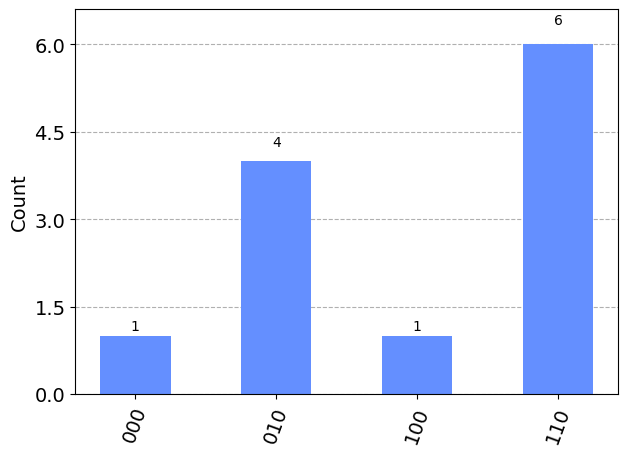

In [227]:
sim = Aer.get_backend('qasm_simulator')
assembled_circuit = assemble(transpiled_circuit, shots=4*n)
sim_job = sim.run(assembled_circuit, noise_model=noise_model)
sim_results = sim_job.result()
sim_counts = sim_results.get_counts()
plot_histogram(sim_counts)

In [228]:
# Constructing the system of linear equations Y s = 0
# By k[::-1], we reverse the order of the bitstring
lAnswer = [ (k[::-1],v) for k,v in sim_counts.items() if k != "0"*n  ] #excluding the trivial all-zero
#Sort the basis by their probabilities
lAnswer.sort(key = lambda x: x[1], reverse=True)

Y = []
for k, v in lAnswer:
    Y.append( [ int(c) for c in k ] )


#import tools from sympy
from sympy import Matrix, pprint, MatrixSymbol, expand

Y = Matrix(Y)

#Perform Gaussian elimination on Y
Y_transformed = Y.rref(iszerofunc=lambda x: x % 2==0) # linear algebra on GF(2) 

print("The hidden bistring s[ 0 ], s[ 1 ]....s[",n-1,"] is the one satisfying the following system of linear equations:")
rows, cols = Y_transformed[0].shape
for r in range(rows):
    Yr = [ "s[ "+str(i)+" ]" for i, v in enumerate(list(Y_transformed[0][r,:])) if v == 1 ]
    if len(Yr) > 0:
        tStr = " + ".join(Yr)
        print(tStr, "= 0")



The hidden bistring s[ 0 ], s[ 1 ]....s[ 2 ] is the one satisfying the following system of linear equations:
s[ 1 ] = 0
s[ 2 ] = 0
